### Dependencies

In [1]:
from utillity_script_cloud_segmentation import *

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


### Load data

In [2]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
submission = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')

hold_out_set = pd.read_csv('../input/clouds-data-split/hold-out.csv')
X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Validation samples: ', len(X_val)) 
print('Test samples:', len(submission))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])

display(X_val.head())

Compete set samples: 22184
Validation samples:  1105
Test samples: 14792


image                                          Fish_mask  \
4420  43dda13.jpg                                                NaN   
4421  3624c8b.jpg                                                NaN   
4422  519820d.jpg  293243 664 294643 664 296043 664 297443 664 29...   
4423  9ede0ba.jpg  860577 8 861977 8 863378 3 863382 6 864777 1 8...   
4424  99b9bd5.jpg  1362214 400 1363614 400 1365014 400 1366414 40...   

                                            Flower_mask  \
4420  2163025 1187 2164425 1187 2165825 1187 2167225...   
4421  1209169 427 1210569 427 1211969 427 1213369 42...   
4422                                                NaN   
4423  1366803 985 1368203 985 1369603 985 1371003 98...   
4424                                                NaN   

                                            Gravel_mask  \
4420  63503 618 64903 618 66303 618 67703 618 69103 ...   
4421  11404 414 12804 414 14204 414 15604 414 17004 ...   
4422                                                NaN   
4423  753290 602 753893 1 753895 4 753901 4 753911 5...   
4424  16067 541 17467 541 18867 541 20267 541 21667 ...   

                                             Sugar_mask  Fish  Flower  Gravel  \
4420  36613 1185 38013 1185 39413 1185 40813 1185 42...     0       1       1   
4421  24824 376 26224 376 27624 376 29024 376 30424 ...     0       1       1   
4422  595022 308 595331 2 595336 2 595340 2 595344 3...     1       0       0   
4423  1 1208 1401 1208 2801 1208 4201 1208 5601 1208...     1       1       1   
4424  428 542 1828 542 3228 542 4628 542 5260 321 60...     1       0       1   

      Sugar         set  
4420      1  validation  
4421      1  validation  
4422      1  validation  
4423      1  validation  
4424      1  validation

# Model parameters

In [3]:
BACKBONE = 'densenet169'
HEIGHT = 256
WIDTH = 384
CHANNELS = 3
N_CLASSES = 4
ADJUST_FN = exposure.adjust_gamma
ADJUST_PARAM = 0.8
label_columns=['Fish', 'Flower', 'Gravel', 'Sugar']

model_path = 'uNet_%s_%sx%s.h5' % (BACKBONE, HEIGHT, WIDTH)
train_images_path = '../input/cloud-images-resized-256x384/train_images256x384/train_images/'
test_images_path = '../input/cloud-images-resized-256x384/test_images256x384/test_images256x384/'
segmentation_model_path = '../input/46unet-densenet169gamma-contrast-adjustment/46-uNet_densenet169_256x384.h5'
# classification_model_path = ''

In [4]:
preprocessing = sm.backbones.get_preprocessing(BACKBONE)

# Model

In [5]:
segmentation_model = load_model(segmentation_model_path, custom_objects={'RAdam':RAdam, 'dice_coef':dice_coef, 'score':sm.metrics.f1_score})
# classification_model = load_model(classification_model_path, custom_objects={'RAdam':RAdam})

### Classification data generator

In [6]:
# datagen=ImageDataGenerator(rescale=1./255.,
#                            horizontal_flip=True,
#                            vertical_flip=True)

# test_datagen=ImageDataGenerator(rescale=1./255.)

# classification_valid_generator=test_datagen.flow_from_dataframe(
#                                             dataframe=X_val,
#                                             directory=train_images_path,
#                                             x_col="image",
#                                             y_col=label_columns,
#                                             target_size=(HEIGHT, WIDTH),
#                                             batch_size=1,
#                                             class_mode="other",
#                                             shuffle=False,
#                                             seed=seed)

# classification_test_generator=test_datagen.flow_from_dataframe(
#                                             dataframe=test,
#                                             directory=test_images_path,
#                                             x_col="image",
#                                             target_size=(HEIGHT, WIDTH),
#                                             class_mode=None,
#                                             batch_size=1,
#                                             shuffle=False,
#                                             seed=seed)

# Segmentation threshold and mask size tunning

In [7]:
mask_grid = [0, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000]
threshold_grid = np.arange(.4, 1, .05)
best_tresholds_seg, best_masks_seg = segmentation_tunning(segmentation_model, train, X_val, train_images_path, label_columns, mask_grid, threshold_grid, N_CLASSES, preprocessing, ADJUST_FN, ADJUST_PARAM, seed)

Fish treshold=0.40 mask size=10000 Dice=0.588
Flower treshold=0.75 mask size=15000 Dice=0.739
Gravel treshold=0.65 mask size=17500 Dice=0.574
Sugar treshold=0.55 mask size=10000 Dice=0.584


# Classification threshold and mask size tunning

In [8]:
# valid_class_preds = classification_model.predict_generator(classification_valid_generator)
# valid_class_labels = classification_valid_generator.labels

# best_tresholds_class = classification_tunning(valid_class_labels, valid_class_preds, label_columns)

# for index, label in enumerate(label_columns):
#   X_val[label+'_pred'] = (valid_class_preds[:,index] > best_tresholds_class[index]).astype(int)

# Model evaluation

In [9]:
train_metrics = get_metrics(segmentation_model, train, X_train, train_images_path, label_columns, best_tresholds_seg, best_masks_seg, seed=seed, preprocessing=preprocessing, adjust_fn=ADJUST_FN, adjust_param=ADJUST_PARAM, set_name='Train')
display(train_metrics)

validation_metrics = get_metrics(segmentation_model, train, X_val, train_images_path, label_columns, best_tresholds_seg, best_masks_seg, seed=seed, preprocessing=preprocessing, adjust_fn=ADJUST_FN, adjust_param=ADJUST_PARAM, set_name='Validation')
display(validation_metrics)

Dice  Dice Post
Class                      
Fish    0.214287   0.594684
Flower  0.194342   0.737775
Gravel  0.220013   0.574340
Sugar   0.248956   0.576144
Train   0.219400   0.620736

Dice  Dice Post
Class                          
Fish        0.217359   0.587895
Flower      0.203432   0.739226
Gravel      0.215726   0.574460
Sugar       0.249860   0.583801
Validation  0.221594   0.621345

## Inspecting some of the validation set predictions

### Without post-process

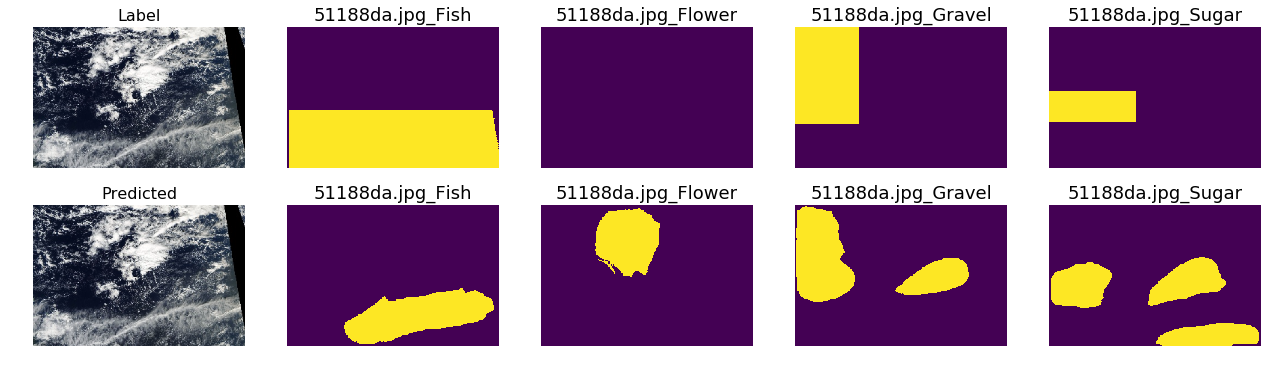

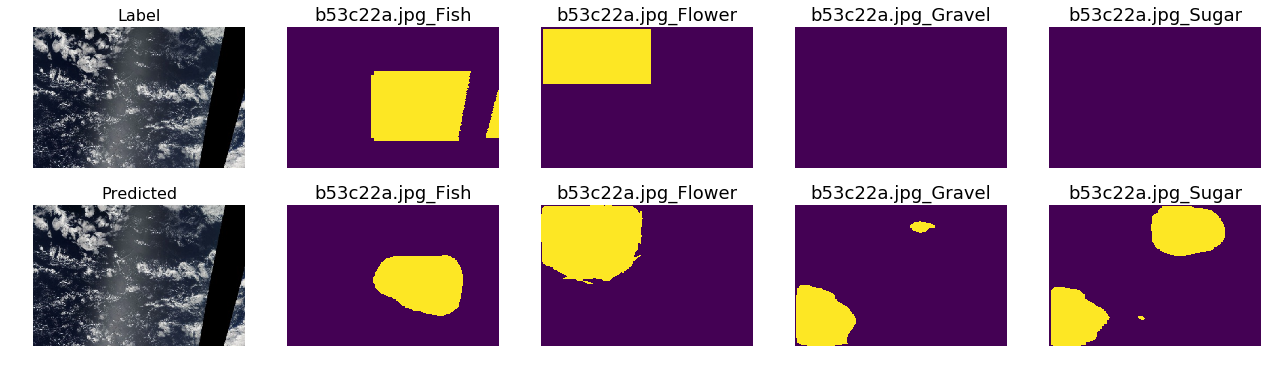

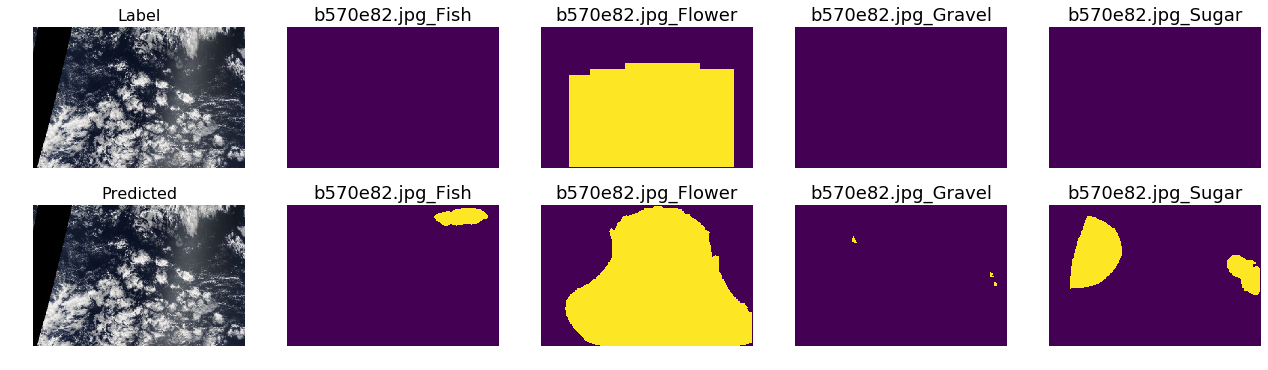

In [10]:
images_to_inspect = np.random.choice(X_val['image'].unique(), 3, replace=False)
inspect_set = train[train['image'].isin(images_to_inspect)].copy()
inspect_set_temp = []

inspect_generator = DataGenerator(
                    directory=train_images_path,
                    dataframe=inspect_set,
                    target_df=train,
                    batch_size=1, 
                    target_size=(HEIGHT, WIDTH),
                    n_channels=CHANNELS,
                    n_classes=N_CLASSES,
                    preprocessing=preprocessing,
                    adjust_fn=ADJUST_FN,
                    adjust_param=ADJUST_PARAM,
                    seed=seed,
                    mode='fit',
                    shuffle=False)

preds = segmentation_model.predict_generator(inspect_generator)

for index, b in enumerate(range(len(preds))):
    filename = inspect_set['image'].iloc[b]
    image_df = inspect_set[inspect_set['image'] == filename].copy()
    pred_masks = preds[index, ].round().astype(int)
    pred_rles = build_rles(pred_masks, reshape=(350, 525))
    image_df['EncodedPixels_pred'] = pred_rles
    
    ### Post procecssing
    pred_masks_post = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks_post[...,class_index]
        pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
        pred_masks_post[...,class_index] = pred_mask

    pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
    image_df['EncodedPixels_pred_post'] = pred_rles_post
    ###
    inspect_set_temp.append(image_df)


inspect_set = pd.concat(inspect_set_temp)
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred')

### With post-process

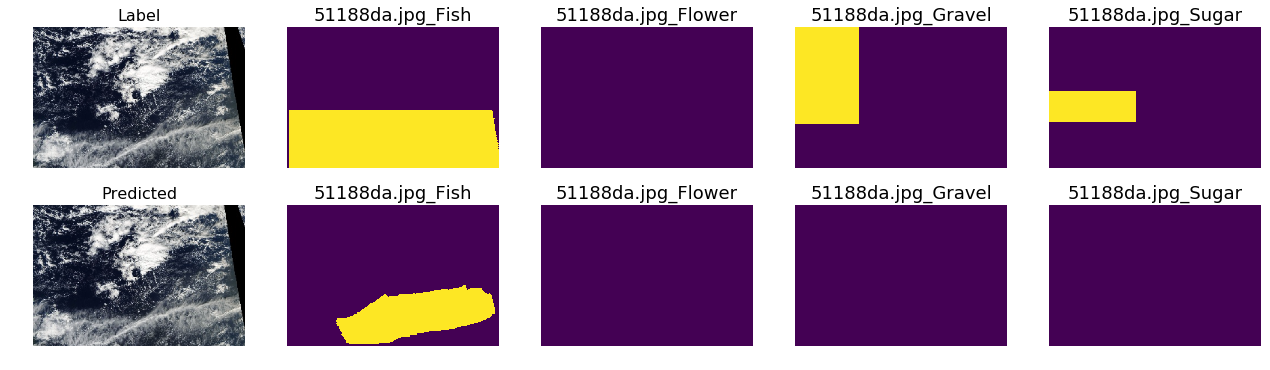

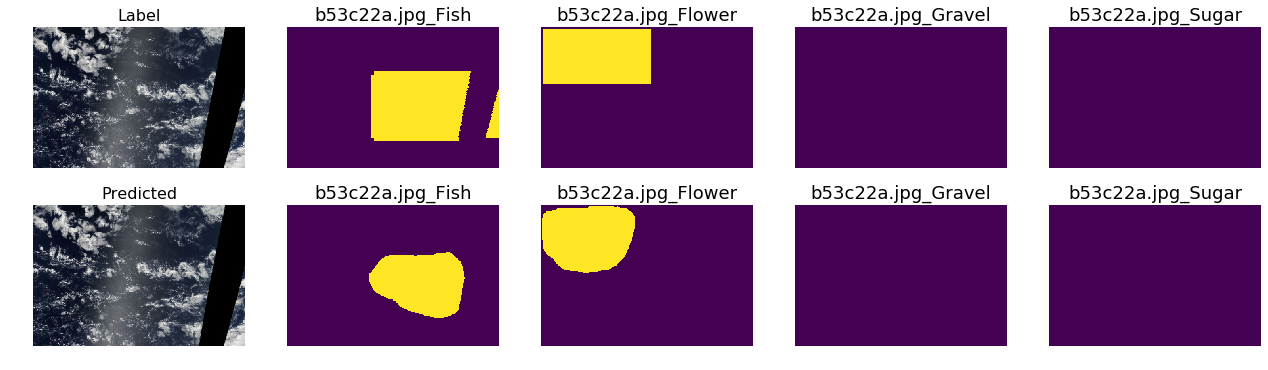

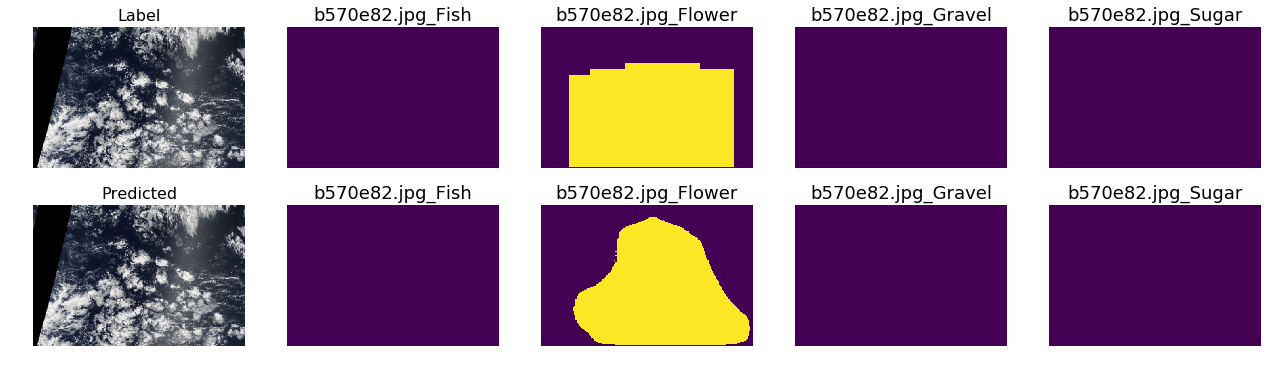

In [11]:
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred_post')

# Apply segmentation model to test set

In [12]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      adjust_fn=ADJUST_FN,
                      adjust_param=ADJUST_PARAM,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = segmentation_model.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32') 
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post'] = pred_rles_post
        ###
        
        test_df.append(image_df)

X_test = pd.concat(test_df)

# Segmentation threshold and mask size tunning for TTA

In [13]:
# Using TTA Wrapper
# segmentation_model_tta = tta_segmentation(segmentation_model, h_flip=True, v_flip=True, h_shift=(-10, 10), v_shift=(-10, 10), merge='mean')
segmentation_model_tta = tta_segmentation(segmentation_model, h_flip=True, v_flip=True, merge='mean')
# best_tresholds_seg_tta, best_masks_seg_tta = segmentation_tunning(segmentation_model_tta, train, X_val, train_images_path, label_columns, mask_grid, threshold_grid, N_CLASSES, preprocessing, ADJUST_FN, ADJUST_PARAM, seed)

# Model evaluation

In [14]:
train_metrics = get_metrics(segmentation_model_tta, train, X_train, train_images_path, label_columns, best_tresholds_seg, best_masks_seg, seed=seed, preprocessing=preprocessing, adjust_fn=ADJUST_FN, adjust_param=ADJUST_PARAM, set_name='Train')
display(train_metrics)

validation_metrics = get_metrics(segmentation_model_tta, train, X_val, train_images_path, label_columns, best_tresholds_seg, best_masks_seg, seed=seed, preprocessing=preprocessing, adjust_fn=ADJUST_FN, adjust_param=ADJUST_PARAM, set_name='Validation')
display(validation_metrics)

Dice  Dice Post
Class                      
Fish    0.214287   0.327581
Flower  0.194342   0.471303
Gravel  0.220013   0.396222
Sugar   0.248956   0.230352
Train   0.219400   0.356365

Dice  Dice Post
Class                          
Fish        0.217359   0.371360
Flower      0.203432   0.416852
Gravel      0.215726   0.376807
Sugar       0.249860   0.233162
Validation  0.221594   0.349545

## Inspecting some of the validation set predictions

### Without post-process and TTA

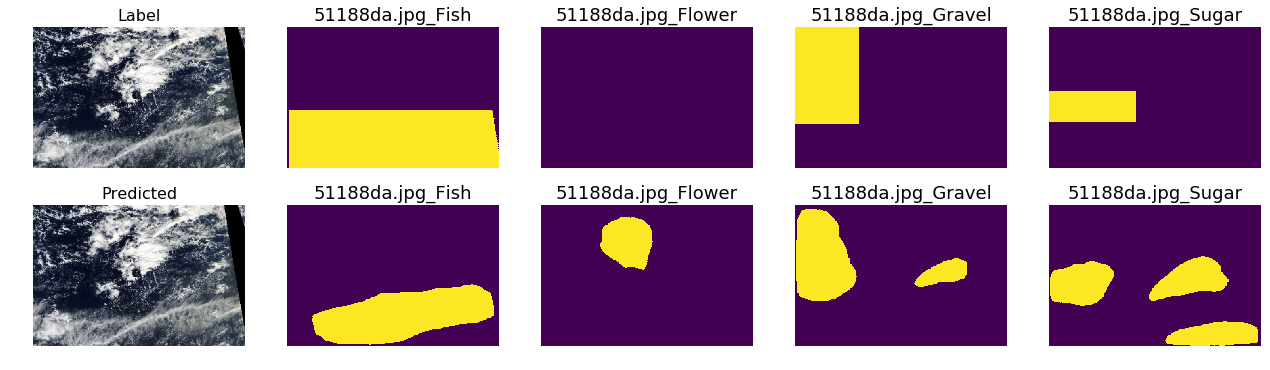

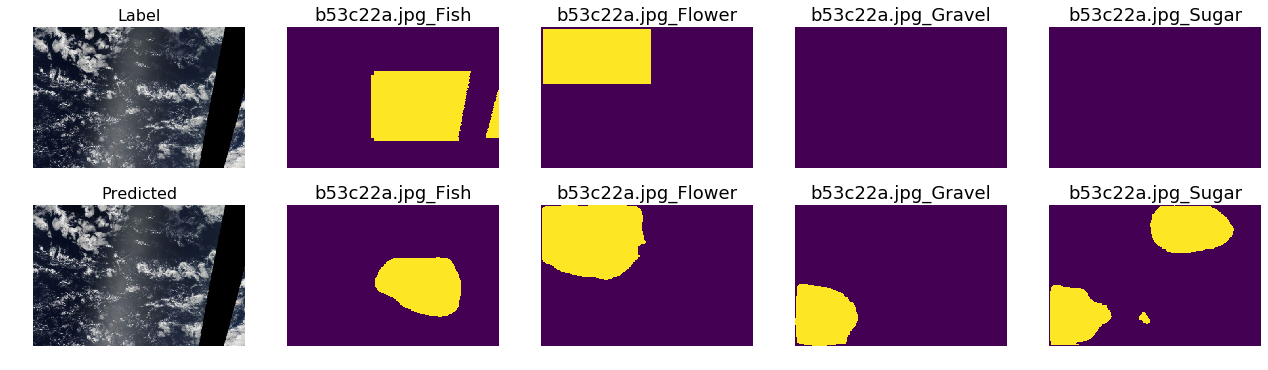

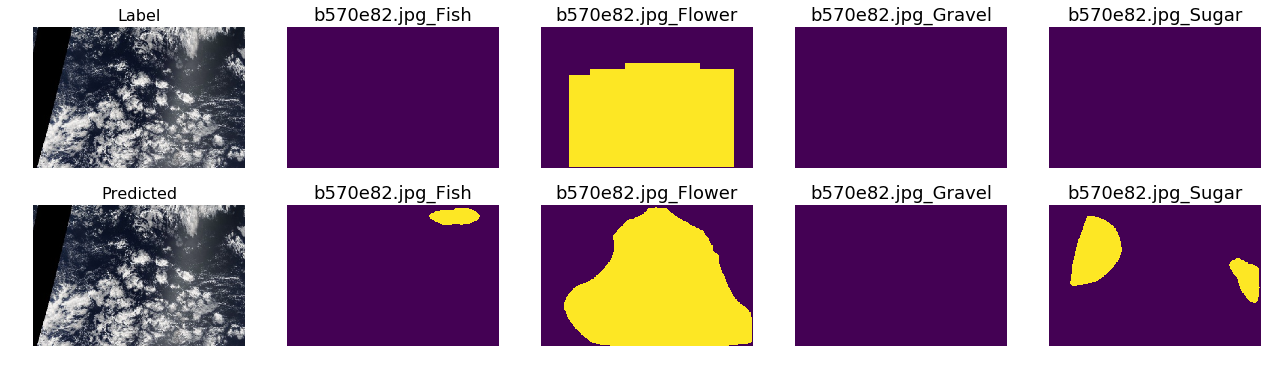

In [15]:
inspect_set = train[train['image'].isin(images_to_inspect)].copy()
inspect_set_temp = []

inspect_generator = DataGenerator(
                    directory=train_images_path,
                    dataframe=inspect_set,
                    target_df=train,
                    batch_size=1, 
                    target_size=(HEIGHT, WIDTH),
                    n_channels=CHANNELS,
                    n_classes=N_CLASSES,
                    preprocessing=preprocessing,
                    adjust_fn=ADJUST_FN,
                    adjust_param=ADJUST_PARAM,
                    seed=seed,
                    mode='fit',
                    shuffle=False)

preds = segmentation_model_tta.predict_generator(inspect_generator)

for index, b in enumerate(range(len(preds))):
    filename = inspect_set['image'].iloc[b]
    image_df = inspect_set[inspect_set['image'] == filename].copy()
    pred_masks = preds[index, ].round().astype(int)
    pred_rles = build_rles(pred_masks, reshape=(350, 525))
    image_df['EncodedPixels_pred'] = pred_rles
    
    ### Post procecssing
    pred_masks_post = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks_post[...,class_index]
        pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
        pred_masks_post[...,class_index] = pred_mask

    pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
    image_df['EncodedPixels_pred_post'] = pred_rles_post
    ###
    inspect_set_temp.append(image_df)


inspect_set = pd.concat(inspect_set_temp)
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred')

### With post-process and TTA

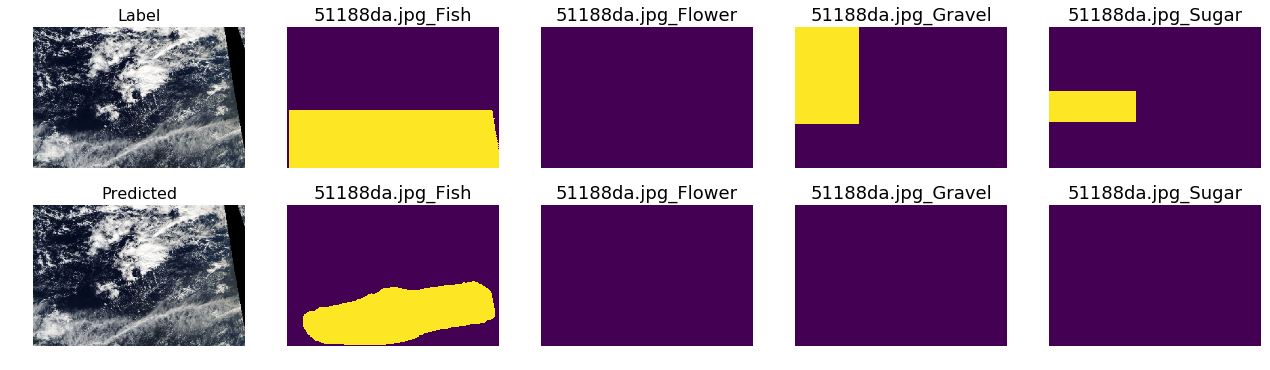

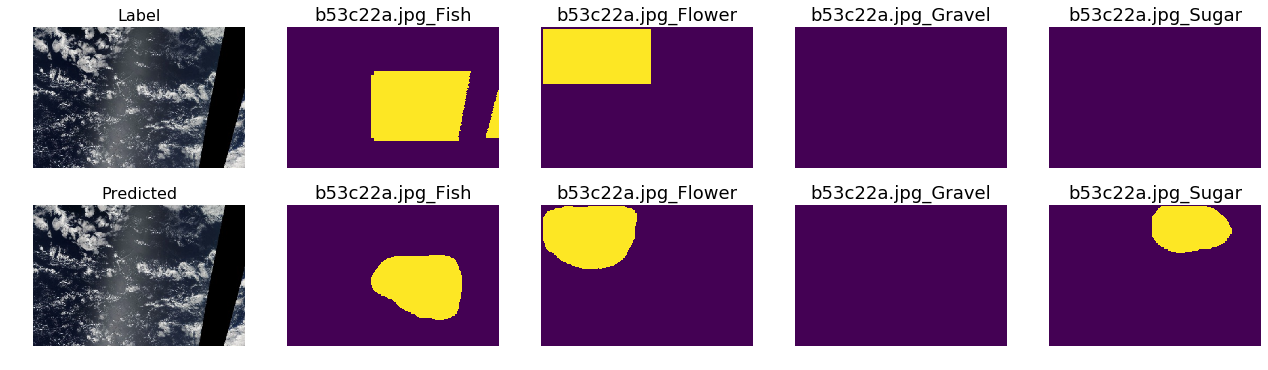

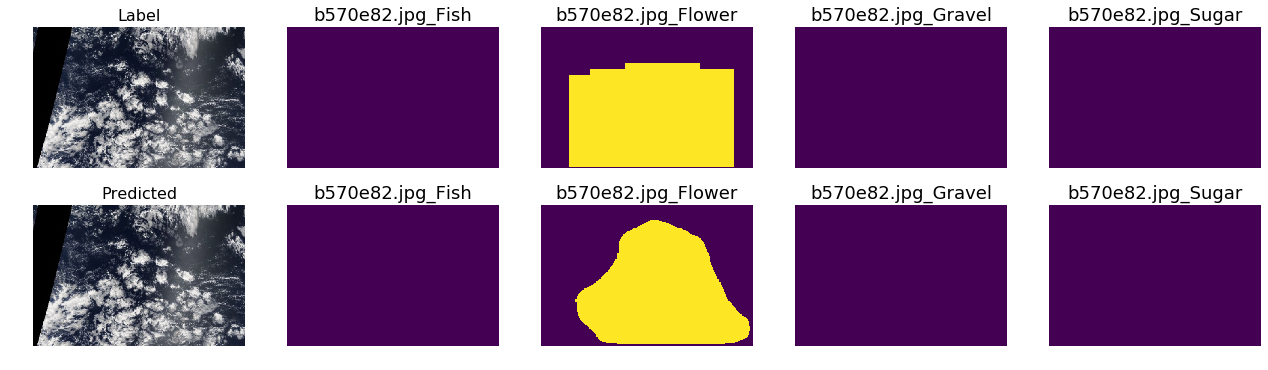

In [16]:
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred_post')

# Apply segmentation model to test set (TTA)

In [17]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      adjust_fn=ADJUST_FN,
                      adjust_param=ADJUST_PARAM,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = segmentation_model_tta.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels_tta'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32') 
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post_tta'] = pred_rles_post
        ###
        
        test_df.append(image_df)

X_test_tta = pd.concat(test_df)

## Inspecting some of the test set predictions

### Without post-process

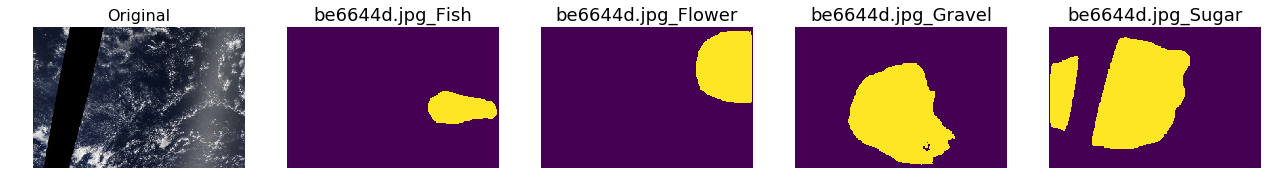

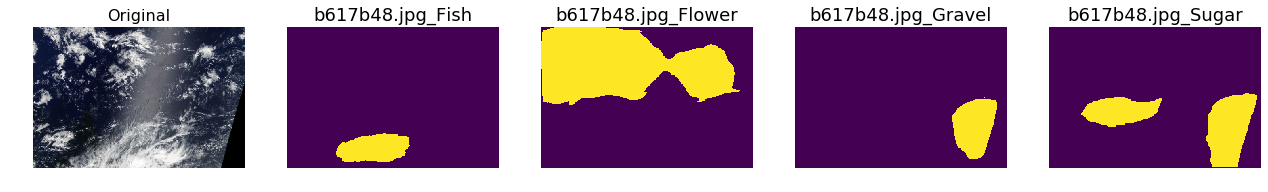

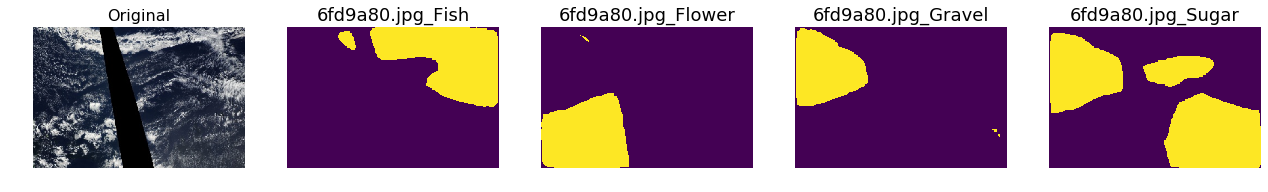

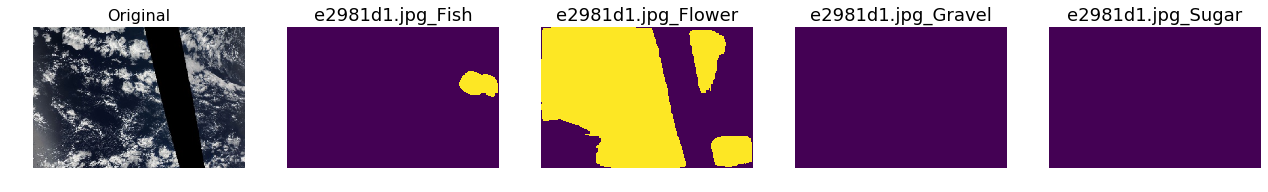

In [18]:
images_to_inspect_test =  np.random.choice(X_test['image'].unique(), 4)
inspect_predictions(X_test, images_to_inspect_test, test_images_path)

### With post-process

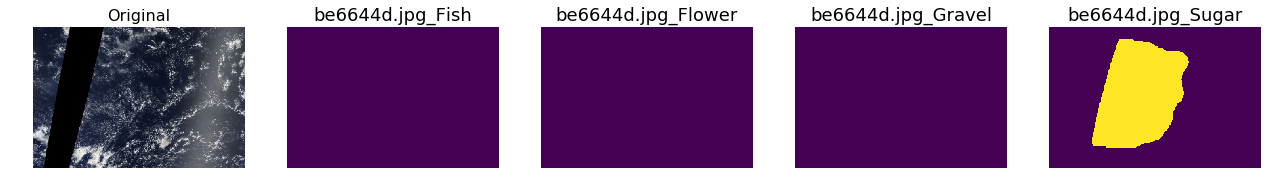

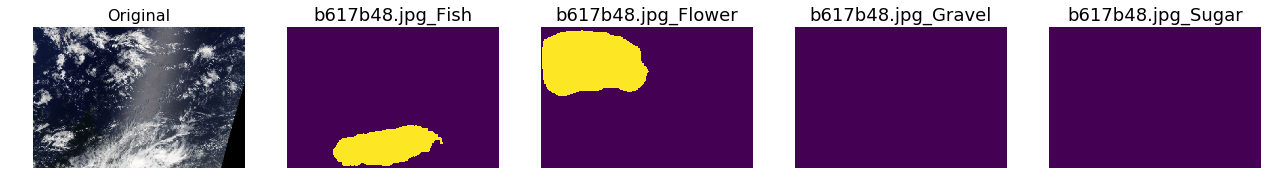

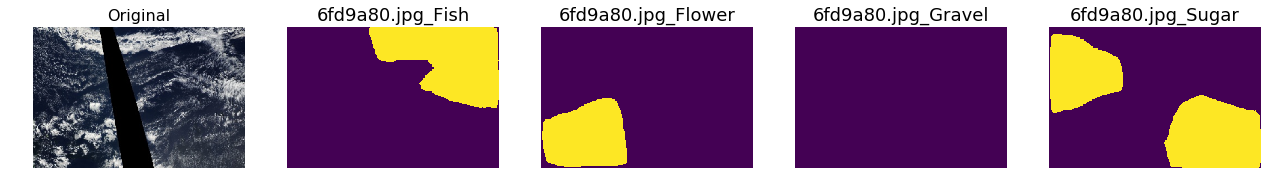

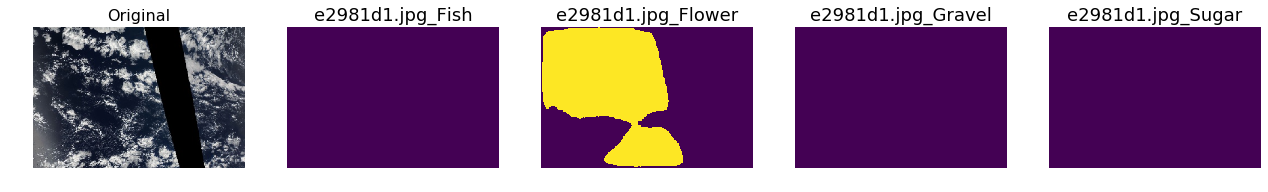

In [19]:
inspect_predictions(X_test, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post')

### Without post-process and TTA

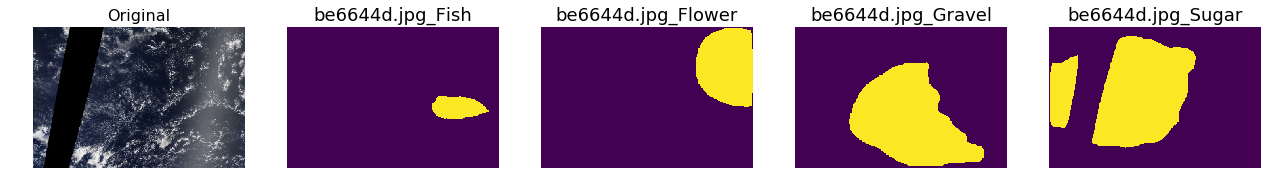

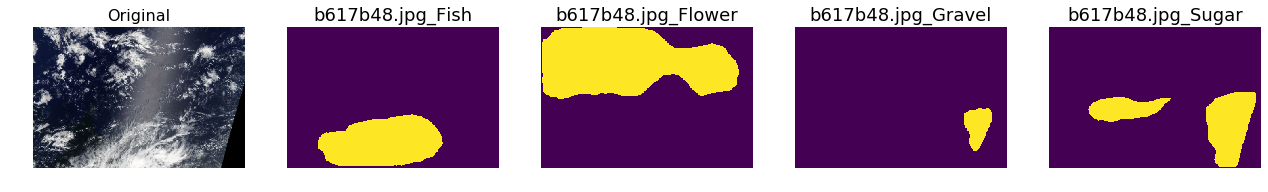

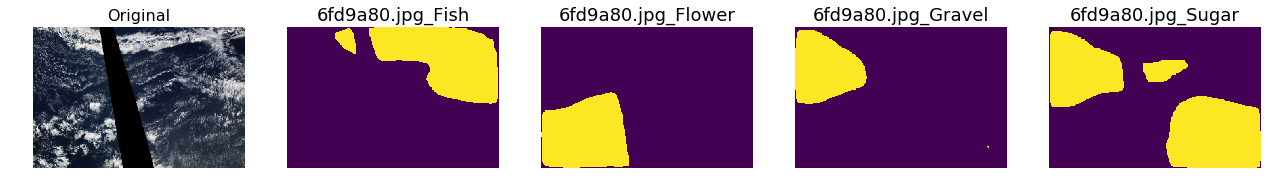

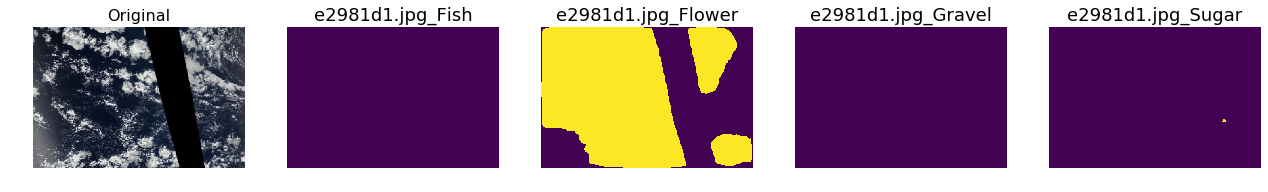

In [20]:
inspect_predictions(X_test_tta, images_to_inspect_test, test_images_path, label_col='EncodedPixels_tta')

### With post-process and TTA

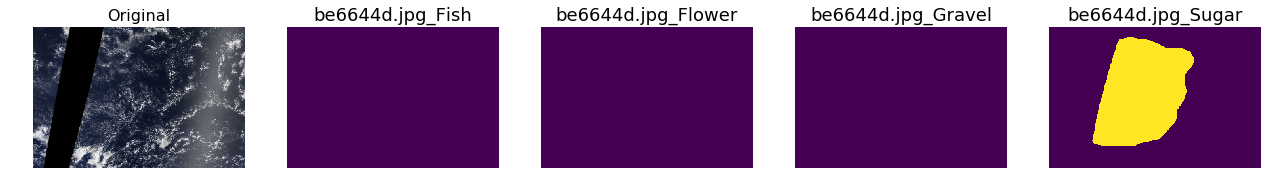

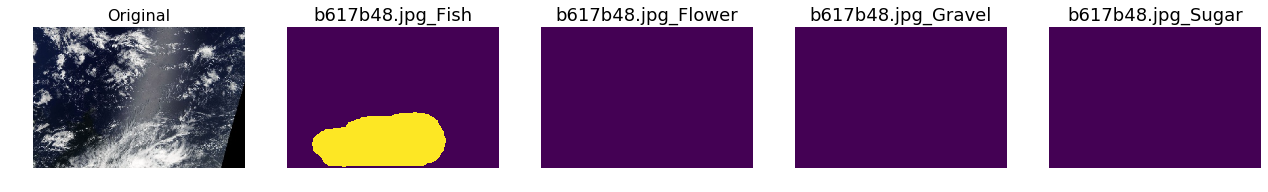

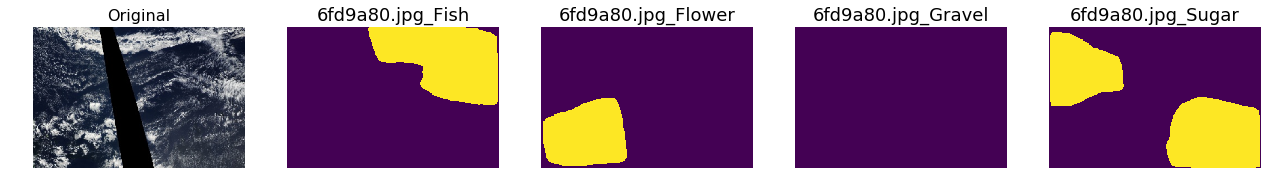

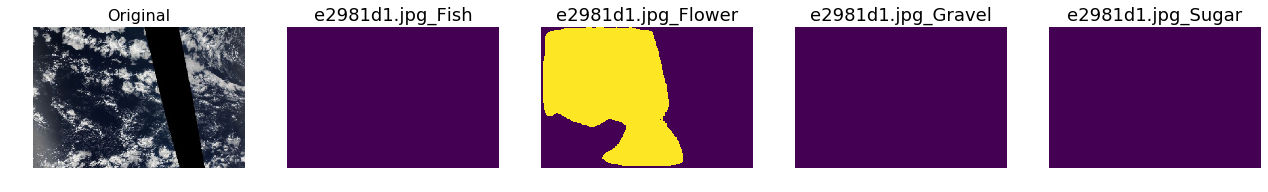

In [21]:
inspect_predictions(X_test_tta, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_tta')

### Regular submission

In [22]:
submission_df = X_test[['Image_Label' ,'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  714 219 941 78 1061 319 1411 319 1757 332 2106...
3   002f507.jpg_Sugar  138784 8 139129 15 139479 15 139828 18 140177 ...
4    0035ae9.jpg_Fish

### Submission with post processing

In [23]:
submission_df_post = X_test[['Image_Label' ,'EncodedPixels_post']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv('submission_post.csv', index=False)
display(submission_df_post.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  734 193 957 47 1069 215 1288 80 1419 215 1638 ...
3   002f507.jpg_Sugar                                                   
4    0035ae9.jpg_Fish

### Submission with post processing and TTA

In [24]:
submission_df_post_class = X_test_tta[['Image_Label' ,'EncodedPixels_post_tta']]
submission_df_post_class.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post_class.to_csv('submission_post_tta.csv', index=False)
display(submission_df_post_class.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  747 179 1074 209 1291 77 1424 209 1641 77 1765...
3   002f507.jpg_Sugar                                                   
4    0035ae9.jpg_Fish